# Graustufenkonvertierung mit NumPy

Hier geht es darum zwei unterschiedliche Herangehensweisen zur Matrix-Verarbeitung mit NumPy zu testen. Insbesondere um einen Vergleich zum naiven C-Modell zu haben. Ziel ist es nicht, die effizienteste Methode zu nehmen - dafür würden sich vorgefertige Befehle besser eignen.

Im ersten Schritt importieren wir die verwendeten Bibliotheken:
- NumPy für die effiziente Speicherung und Verarbeitung von Arrays und damit Matrizen
- Matplotlib um Bilder einzulesen und darzustellen - sowie für Schaubilder
- perf_counter aus der time Standardbibliothek zur Zeitmessung

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from time import perf_counter

Nun lesen wir das Bild ein und geben die "Form" ("shape") des Bilds aus:

In [41]:
img = plt.imread("tamanna-rumee-vaTsR-ghLog-unsplash.jpg")
imOpencv = cv2.imread("tamanna-rumee-vaTsR-ghLog-unsplash.jpg")
print(img.shape)

(5472, 3648, 3)


Die Form ist ein 3-Tupel aus Ganzzahlen. Das heißt wir haben hier ein 3-dimensionales Array mit den Dimensionen:
- Höhe: 5472 entspricht den Zeilen des Bilds
- Breite: 3648 entspricht den Spalten des Bilds
- Kanäle: 3 entspricht den Farbkomponenten des Bidls (Rot, Grün, Blau)

Wir können nun einzelne Bereiche des Bilds als Daten/Zahlen betrachten:

In [3]:
# Erster Pixel als RGB-Array
img[0,0,:]

array([ 79, 175, 191], dtype=uint8)

In [4]:
# Blau Werte der 9 Pixel "rechts-unten"
img[-4:-1,-4:-1,2]

array([[52, 53, 55],
       [51, 53, 55],
       [52, 54, 56]], dtype=uint8)

Mit Matplotlib können wir aber auch das gesamte Bild plotten:

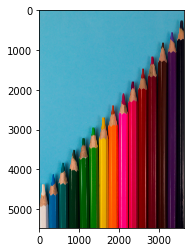

In [5]:
plt.imshow(img)
plt.show()

Wir können auch die Farbkanäle einzelnen plotten:

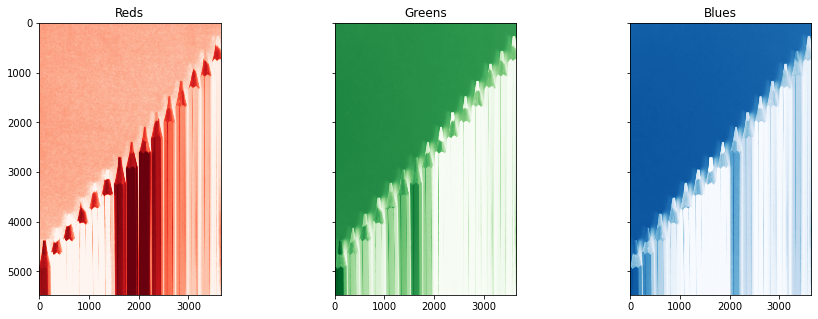

In [6]:
colors = ["Reds", "Greens", "Blues"]

fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15,5))

for i in range(3):
    ax[i].set_title(colors[i])
    ax[i].imshow(img[:,:,i],cmap=colors[i])

## Serielle Konvertierung

Wir können nun natürlich in Python genau so eine serielle Schleife programmieren wie in C. Warnung: die Ausführung wird lange dauern - das Programm verstößt gegen alle NumPy Best Practices.

In [7]:
height = img.shape[0]
width = img.shape[1]

# Anlegen eines leeren Bilds
gray = np.empty(shape=(height, width), dtype=np.uint8)

# Doppelter for-loop für jedes Pixel einzelne Konvertierung
start = perf_counter()
for x in range(width):
    for y in range(height):
        gray[y, x] = 0.2126 * img[y, x, 0] + 0.7152 * img[y, x, 1] + 0.0722 * img[y, x, 2]
secs = perf_counter() - start

KeyboardInterrupt: 

In [ ]:
flop = width * height * (3 + 2)
print(f'{flop/1000000.0:8.2f} MFLOP')
mflops = flop / 1000000.0 / secs
print(f'{mflops:8.2f} MFLOP/s');

Seeeeeeehr langsam gegenüber unseres C-Programms. Aber einfach darzustellen:

In [ ]:
plt.imshow(gray, cmap="gray")
plt.show()

Wir können auch die Berechnung für einen Pixel sehr leicht nachvollziehen und prüfen:

In [ ]:
img[0,0]

In [ ]:
79*0.2126+175*0.7152+191*0.0722

In [ ]:
gray[0,0]

# Matrix-Multiplikation

Wenn wir das RGB-Bild wieder als 2D-Array abspeichern wie in C, dann können wir die Graustufenkonvertierung auch über eine [Matrix-Multiplikation](https://de.wikipedia.org/wiki/Matrizenmultiplikation) erreichen. Im Folgenden ist die Vorgehensweise skizziert:

![Graustufenkonvertierung als Matrix-Multiplikation](graustufenmatrixmul.svg)

Zunächst konvertieren wir das 3D-Array in ein 2D-Array. NumPy hat dafür die reshape-Operation: wir geben die erste Dimension mit der Höhe an und sagen dann mit -1, dass die zweite Dimension berechnet werden soll:

In [ ]:
img2dmatrix = img.reshape(height,-1)
img2dmatrix

Die Transformationsmatrix ist etwas komplizierter zu erstellen. Zunächst erstellen wir Identitäts-Matrizen, d.h. mit 1en in der Diagonale. Diese multiplizieren wir dann mit den Farbgewichten und verweben Sie dann untereinander. Dies erfordert in NumPy ein paar Umwegen und ist daher hier vorgegeben:

In [ ]:
transformation = np.hstack((np.identity(width)*0.2126, np.identity(width)*0.7152,np.identity(width)*0.0722)).reshape(-1,width)
transformation

Nun bleibt uns nur noch die Matrix-Multiplikation auszuführen und das Bild anzuzeigen:

In [ ]:
gray_matrix = np.matmul(img2dmatrix, transformation)

In [ ]:
plt.imshow(gray_matrix, cmap="gray")
plt.show()

Das geht erheblich schneller als die geschachtelten Schleifen aber dennoch langsamer als unsere C-Lösung. Wir haben das Problem aber auch mit einer Matrix-Multiplikation.
Ein einfacher Algorithmus für Matrix-Multiplikation (wird so von NumPy nicht verwendet) funktioniert so:
```
def matmul(A, B):
    if A.shape[1] != B.shape[0]:
        return []
    C = np.empty(shape=(A.shape[0], B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            sum = 0
            for k in range(A.shape[1]):
                sum += A[i,k] * B[k,j]
            C[i,j] = sum
```

- Wie viele FLOP hätten berechnet werden müssen, um die Matrix-Multiplikation durchzuführen?
- Wie viele MFLOP/s wären es gewesen, wenn Sie die Zeit der NumPy-Multiplikation auf diese FLOP anwenden?
- Wie vergleicht sich das mit der C-Variante?

In [ ]:
# TODO

## NumPy Matrix-Operationen

Gehen wir zurück zu `img` indem das RGB-Bild als 3D-Array abgelegt ist. NumPy bietet Matrix-Operationen, d.h. wir können direkt Arrays miteinander addieren - NumPy sorgt dann für eine optimierte Elementweise Addition.
Beispiel:

In [8]:
a = np.array([1, 2, 3, 4, 5])
b = np.array([6, 7, 8, 9, 10])
a + b

array([ 7,  9, 11, 13, 15])

Ebenso können z.B. Arrays mit einem Skalar-Wert addiert oder multipliziert werden:

In [ ]:
a * 0.4

Ein weiteres Feature ist der effiziente Zugriff auf Teil-Arrays. Die einfachste Methode ist dabei `:` für eine Dimension zu nutzen, wenn alle Werte aus dieser Dimension gewünscht sind.
Z.B. liefert die folgende Zeile alle Grün-Werte der ersten Zeile des Bilds:

In [39]:
img[0,:,1]

array([175, 174, 174, ..., 163, 162, 162], dtype=uint8)

*Aufgabe*:
- Erstellen Sie ein Graustufenbild als Matrix-Operation
- Messen Sie die Zeit
- Berechnen Sie die MFLOP/s mit der benötigten FLOP-Zahl wie bei der doppelten Schleife

In [42]:
#openCV grayscale 
height = imOpencv.shape[0]
width = imOpencv.shape[1]
start = perf_counter()
imOpencv = cv2.cvtColor(imOpencv,cv2.COLOR_BGR2GRAY)
end = perf_counter() - start
cv2.imwrite("openCVGray.jpg", imOpencv)
flop = width * height * (3 + 2)
mflops = flop / 1000000.0 / end
print( "time" )
print( end)
print( "flop")
print( flop)
print( "mflops")
print( mflops)

time
0.008900499999981548
flop
99809280
mflops
11213.895848571083


In [43]:
#normal grayscale 
height = img.shape[0]
width = img.shape[1]
start = perf_counter()
graynp = img[:,:,0] * 0.2126 + img[:,:,1] * 0.7152 + img[:,:,2] * 0.0722
end = perf_counter() - start
flop = width * height * (3 + 2)
mflops = flop / 1000000.0 / end
print( "time" )
print( end)
print( "flop")
print( flop)
print( "mflops")
print( mflops)




time
0.292279199999939
flop
99809280
mflops
341.48608590697125
